# Import appropriate packages and set analysis options.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
from math import sqrt

print_all_output = True
InteractiveShell.ast_node_interactivity = 'all' if print_all_output else 'last_expr'

# Define convenient variables and functions.

In [2]:
TRAINING_DATA_PATH = "./Data/train.csv"

# The MAGIC_SEED simply fixes the random state/
# seed so that the same random replacements
# can be repeatedly used in this notebook
# if it's reevaluated.
MAGIC_SEED = 1776

def load_data(path):
    """
    Load the file at 'path' into a Pandas
    DataFrame.
    """
    df = pd.read_csv(path, header=0, index_col='Id')
    print("Loaded data dimensions: ", df.shape[0], "rows, ", df.shape[1], "columns")
    return df

def print_if_nan(df, col_type):
    """
    Print all DataFrame columns of type col_type
    which contain NaN values.
    """
    if (col_type == "int"):
        columns = x_train.select_dtypes(include=['int']).columns
    elif (col_type == "float"):
        columns = x_train.select_dtypes(include=['float']).columns
    else:
        columns = x_train.select_dtypes(include=['object']).columns
    nan_cols = []
    nan_counts = []
    for col in np.sort(columns):
        num_nan = np.sum(x_train[col].isnull())
        if (num_nan > 0):
            nan_cols.append(col)
            nan_counts.append(num_nan)
    print("\n", len(nan_cols), " ", col_type, "-type columns with NaN values.", sep='')
    for col, count in zip(nan_cols, nan_counts):
          print(col, "\t", count)
            
def replace_with_normal(df, col, seed = np.random.seed()):
    """
    Replace NaN values in a DataFrame column with
    values chosen from a normal distribution with
    a mean and standard deviation equal to the
    that of the non-NaN data.
    """
    np.random.seed(seed)
    df_dropped = df[col].dropna()
    mu = np.mean(df_dropped)
    sigma = np.std(df_dropped)
    null_rows = df[col].isnull()
    num_nan = np.sum(null_rows)
    rand_vals = np.random.normal(mu, sigma, num_nan)
    df.loc[null_rows, col] = rand_vals
    
def most_common_label(df, col):
    most_common_appearances = 0
    most_common_label = ""
    for label in df[col].unique():
        num_appearances = np.sum(x_train[col] == label)
        if (num_appearances > most_common_appearances):
            most_common_appearances = num_appearances
            most_common_label = label
    return most_common_label

# Load and preview the housing training data.

In [3]:
df = load_data(TRAINING_DATA_PATH)

Loaded data dimensions:  1460 rows,  80 columns


In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Clean and process the training data.

In [6]:
# Partition data into features (X-data) and
# targets (Y-data).
x_train = df.iloc[:,:79]
y_train = df.iloc[:,79]

In [7]:
# Determine which features have missing values.
print_if_nan(x_train, "int")
print_if_nan(x_train, "float")
print_if_nan(x_train, "string")


0 int-type columns with NaN values.

3 float-type columns with NaN values.
GarageYrBlt 	 81
LotFrontage 	 259
MasVnrArea 	 8

16 string-type columns with NaN values.
Alley 	 1369
BsmtCond 	 37
BsmtExposure 	 38
BsmtFinType1 	 37
BsmtFinType2 	 38
BsmtQual 	 37
Electrical 	 1
Fence 	 1179
FireplaceQu 	 690
GarageCond 	 81
GarageFinish 	 81
GarageQual 	 81
GarageType 	 81
MasVnrType 	 8
MiscFeature 	 1406
PoolQC 	 1453


In [8]:
# View distribution details for the float-type
# features which have missing values. This will
# provide some insight on how to handle their
# missing values.
x_train['GarageYrBlt'].describe()
x_train['LotFrontage'].describe()
x_train['MasVnrArea'].describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [9]:
# Since 'GarageYrBlt' and 'LotFrontage' have
# means which are similar to their medians,
# their distributions aren't very skewed. It's
# probably safe to replace NaNs with the
# medians, but the approach that will be taken
# is to replace missing values with values
# randomly selected from a normal distribution
# with the same mean and standard deviation.
replace_with_normal(x_train, 'GarageYrBlt', MAGIC_SEED)
replace_with_normal(x_train, 'LotFrontage', MAGIC_SEED)

In [10]:
# There are very few 'MasVnrArea' with NaN values,
# but since the mean and median are very different,
# a normal distribution doesn't describe this data
# set very well. In this case, just replace NaNs
# with the median.
x_train.loc[:,'MasVnrArea'] = preprocessing.Imputer(strategy='mean').fit_transform(df['MasVnrArea'].values.reshape(-1,1))

In [11]:
# Convert all string-like feature NaN's to
# None so that label encoding can convert
# the remaining categorical data to ints.
for col in x_train.select_dtypes(include=['object']).columns:
    x_train.loc[x_train[col].isnull(), col] = 'None'
le = preprocessing.LabelEncoder()
for col in x_train.select_dtypes(include=['object']).columns:
    le.fit(x_train[col].unique())
    x_train.loc[:, col] = le.transform(x_train[col])

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [12]:
# At this point, the DataFrame should be free of
# missing values.
print_if_nan(x_train, "int")
print_if_nan(x_train, "float")
print_if_nan(x_train, "string")
x_train.head()


0 int-type columns with NaN values.

0 float-type columns with NaN values.

0 string-type columns with NaN values.


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,65.0,8450,1,1,3,3,0,4,...,0,0,3,4,1,0,2,2008,8,4
2,20,3,80.0,9600,1,1,3,3,0,2,...,0,0,3,4,1,0,5,2007,8,4
3,60,3,68.0,11250,1,1,0,3,0,4,...,0,0,3,4,1,0,9,2008,8,4
4,70,3,60.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
5,60,3,84.0,14260,1,1,0,3,0,2,...,0,0,3,4,1,0,12,2008,8,4


# Feature engineering: pick out or generate relevant metrics that may not be directly provided in the data.

In [13]:
### cols = x_train.columns.tolist()
### cols_with_SF = [s for s in cols if "SF" in s]
x_train['BsmtFinSF'] = x_train['TotalBsmtSF'] - x_train['BsmtUnfSF']
x_train['EnclosedSF'] = x_train['BsmtFinSF'] + x_train['1stFlrSF'] + x_train['2ndFlrSF']

# Train models for predictions.

## Tentatively split the training data into subsets.

In [14]:
x_train1, x_train2, y_train1, y_train2 = train_test_split(
    x_train, y_train, test_size=0.5, random_state=MAGIC_SEED)

## Primitive model: linear regression.

In [15]:
# Create the linear regression object and
# train it on the target data.
lin_regr = linear_model.LinearRegression()
lin_regr.fit(x_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
# Test the model: predict home prices.
y_train2_pred = lin_regr.predict(x_train2)

RMS Error: 36380.843
Variance score: 0.770


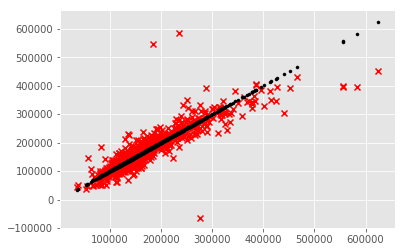

In [17]:
# Evaluate the prediction by viewing the
# coefficients, error, and variance (where
# a variance of 1 indicates a perfect
# prediction).
#print('Coefficients: \n', lin_regr.coef_)
print("RMS Error: %.3f"
      % sqrt(mean_squared_error(y_train2, y_train2_pred)))
print('Variance score: %.3f' % r2_score(y_train2, y_train2_pred))

# Plot outputs
plt.scatter(y_train2, y_train2_pred, color='red', marker='x')
plt.scatter(y_train2, y_train2, color='black', marker='.')
plt.show()
plt.legend(('Linear Regression', "True Prices"));